In [1]:
# =====================================================================
# LOAD DATA AND SETUP
# =====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Muted color palette
COLORS = ['#2C3E50', '#34495E', '#7F8C8D', '#95A5A6', '#BDC3C7']
ACCENT = '#3498DB'

# Load data
df = pd.read_csv('merged_data_clean.csv')
print(f"Data loaded: {df.shape}")

Data loaded: (2254, 40)


In [16]:
# === Robust setup & helpers ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import warnings

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

COLORS = ['#2C3E50', '#34495E', '#7F8C8D', '#95A5A6', '#BDC3C7']
ACCENT = '#3498DB'

# safe polyfit/trendline - returns (has_trend, coeffs, r_squared)
def safe_trendline(x, y, deg=1, min_points=3):
    x = np.array(x)
    y = np.array(y)
    # drop nan
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]; y = y[mask]
    if len(x) < min_points or np.nanmax(x) - np.nanmin(x) == 0:
        return False, None, np.nan
    try:
        coeffs = np.polyfit(x, y, deg)
        p = np.poly1d(coeffs)
        yhat = p(x)
        # R^2
        ss_res = np.sum((y - yhat)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
        return True, coeffs, r2
    except Exception:
        return False, None, np.nan

# euro formatter
euro_fmt = mtick.FuncFormatter(lambda x, p: f'€{x:,.0f}')
pct_fmt = mtick.PercentFormatter(xmax=1.0)


In [17]:
# === Load and sanitize ===
df = pd.read_csv('merged_data_clean.csv')
print("raw shape:", df.shape)

# Convert columns we expect numeric to numeric (coerce errors -> NaN)
num_cols = ['CA_Total','Nombre_Resa_Total','CA_Agence','Nombre_Resa_Agence',
            'CA_Web','Nombre_Resa_Web','NPS','Nombre de répondants','Nbre_Foyers']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
# Normalize common column names if they have spaces or accents issues:
if 'Nombre de répondants' in df.columns and 'respondents' not in df.columns:
    df.rename(columns={'Nombre de répondants': 'respondents'}, inplace=True)

# replace zero denominators with NaN for ratio computations
df['Nombre_Resa_Total'] = df['Nombre_Resa_Total'].replace({0: np.nan})
df['CA_Total'] = df['CA_Total'].replace({0: np.nan})

print("cleaned shape:", df.shape)


raw shape: (2254, 40)
cleaned shape: (2254, 40)


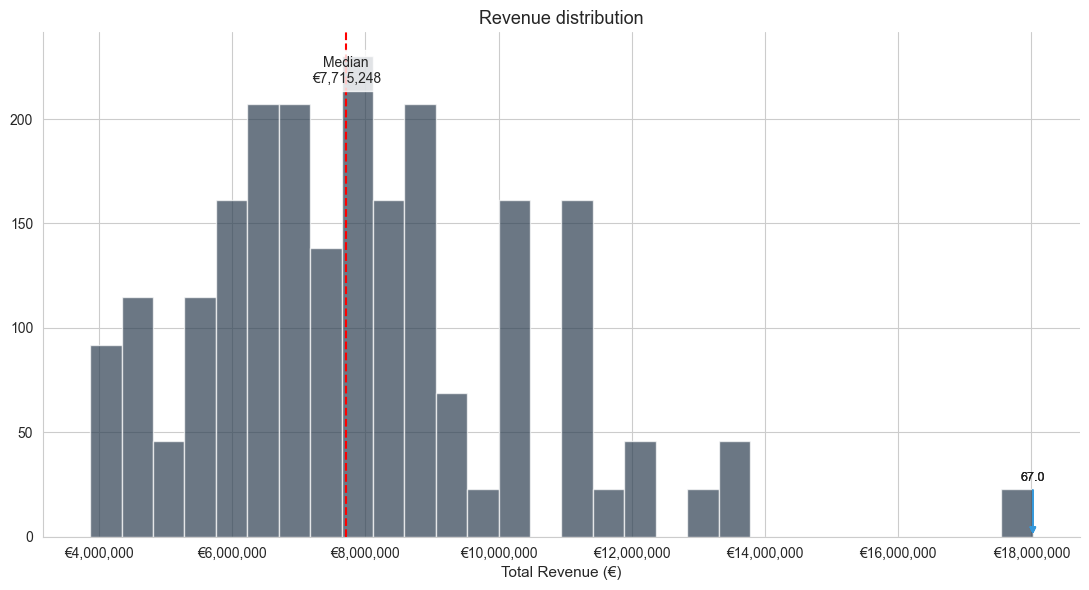

In [18]:
# === Revenue distribution with log option and annotations ===
revenue = df['CA_Total'].dropna()

fig, ax = plt.subplots(figsize=(11,6))
# choose linear or log depending on skewness
skewness = revenue.skew()
use_log = skewness > 2.0  # heuristic: if very skewed, show log

if use_log:
    ax.hist(np.log10(revenue), bins=30, alpha=0.7, color=COLORS[0], edgecolor='white', density=False)
    ax.set_xlabel('Log10(Total Revenue)')
    # annotate median & mean in original scale
    med = revenue.median(); mean = revenue.mean()
    ax.set_title('Revenue distribution (log10 scale) — heavily skewed')
    ax.text(0.98, 0.95, f'Median: €{med:,.0f}\nMean: €{mean:,.0f}',
            transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
else:
    ax.hist(revenue, bins=30, alpha=0.7, color=COLORS[0], edgecolor='white')
    ax.set_xlabel('Total Revenue (€)')
    ax.set_title('Revenue distribution')
    med = revenue.median(); mean = revenue.mean()
    ax.axvline(med, color='red', linestyle='--', linewidth=1.5)
    ax.text(med, ax.get_ylim()[1]*0.9, f'Median\n€{med:,.0f}', ha='center', bbox=dict(facecolor='white', alpha=0.8))
    ax.xaxis.set_major_formatter(euro_fmt)

# Annotate top 3 agencies (original scale)
top3 = df.nlargest(3, 'CA_Total')[['agency_id','CA_Total']].dropna()
for _, row in top3.iterrows():
    if use_log:
        x = np.log10(row['CA_Total'])
    else:
        x = row['CA_Total']
    ax.annotate(row['agency_id'], xy=(x, 0), xycoords=('data','axes fraction'),
                xytext=(0, 40), textcoords='offset points', ha='center', fontsize=9,
                arrowprops=dict(arrowstyle='-|>', color=ACCENT, lw=1.2))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
fig.savefig('fig_revenue_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


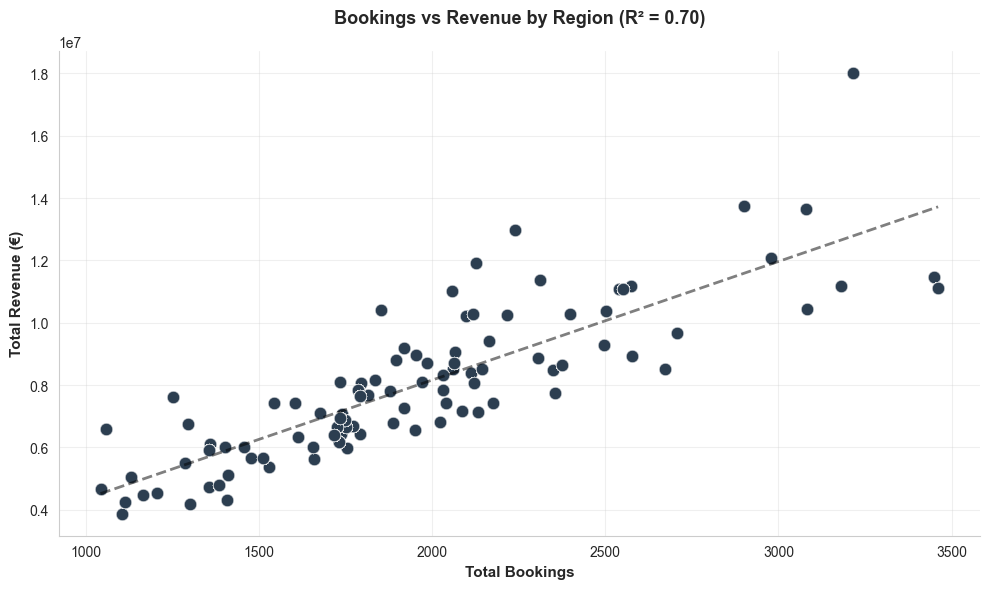

In [3]:
# =====================================================================
# 2. SCATTER PLOT: BOOKINGS VS REVENUE (COLORED BY REGION)
# =====================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Remove NaN
plot_data = df.dropna(subset=['Nombre_Resa_Total', 'CA_Total'])

# Get unique regions for color mapping
if 'Region' in df.columns:
    regions = plot_data['Region'].unique()
    color_map = dict(zip(regions, sns.color_palette('muted', len(regions))))
    
    for region in regions:
        region_data = plot_data[plot_data['Region'] == region]
        ax.scatter(region_data['Nombre_Resa_Total'], 
                  region_data['CA_Total'], 
                  alpha=0.6, 
                  s=80,
                  label=region,
                  color=color_map[region],
                  edgecolors='white',
                  linewidth=0.5)
else:
    ax.scatter(plot_data['Nombre_Resa_Total'], 
              plot_data['CA_Total'], 
              alpha=0.6, 
              s=80,
              color=COLORS[0],
              edgecolors='white',
              linewidth=0.5)

# Add trend line
z = np.polyfit(plot_data['Nombre_Resa_Total'], plot_data['CA_Total'], 1)
p = np.poly1d(z)
x_trend = np.linspace(plot_data['Nombre_Resa_Total'].min(), plot_data['Nombre_Resa_Total'].max(), 100)
ax.plot(x_trend, p(x_trend), "--", color='black', linewidth=2, alpha=0.5, label='Trend')

# Calculate R²
correlation = np.corrcoef(plot_data['Nombre_Resa_Total'], plot_data['CA_Total'])[0,1]
r_squared = correlation**2

# Formatting
ax.set_xlabel('Total Bookings', fontweight='bold')
ax.set_ylabel('Total Revenue (€)', fontweight='bold')
ax.set_title(f'Bookings vs Revenue by Region (R² = {r_squared:.2f})', fontweight='bold', pad=20)
if 'Region' in df.columns:
    ax.legend(frameon=False, loc='best', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# === Safe ratio computation ===
# Loyalty penetration = loyalty households / bookings (households per bookings)
if 'Nbre_Foyers' in df.columns and 'Nombre_Resa_Total' in df.columns:
    df['loyalty_penetration'] = df['Nbre_Foyers'] / df['Nombre_Resa_Total']
    df['loyalty_penetration'] = df['loyalty_penetration'].replace([np.inf, -np.inf], np.nan)

# Web share
if 'CA_Web' in df.columns and 'CA_Total' in df.columns:
    df['web_share'] = df['CA_Web'] / df['CA_Total']
    df['web_share'] = df['web_share'].replace([np.inf, -np.inf], np.nan)

# Quick sanity summary of new ratios
print("loyalty penetration: n={}, median={:.2%}".format(df['loyalty_penetration'].notna().sum(), df['loyalty_penetration'].median(skipna=True)))
print("web share: n={}, median={:.2%}".format(df['web_share'].notna().sum(), df['web_share'].median(skipna=True)))


loyalty penetration: n=2254, median=502.68%
web share: n=2254, median=11.21%


C:\Users\Hp\AppData\Local\Temp\ipykernel_15764\4047527426.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


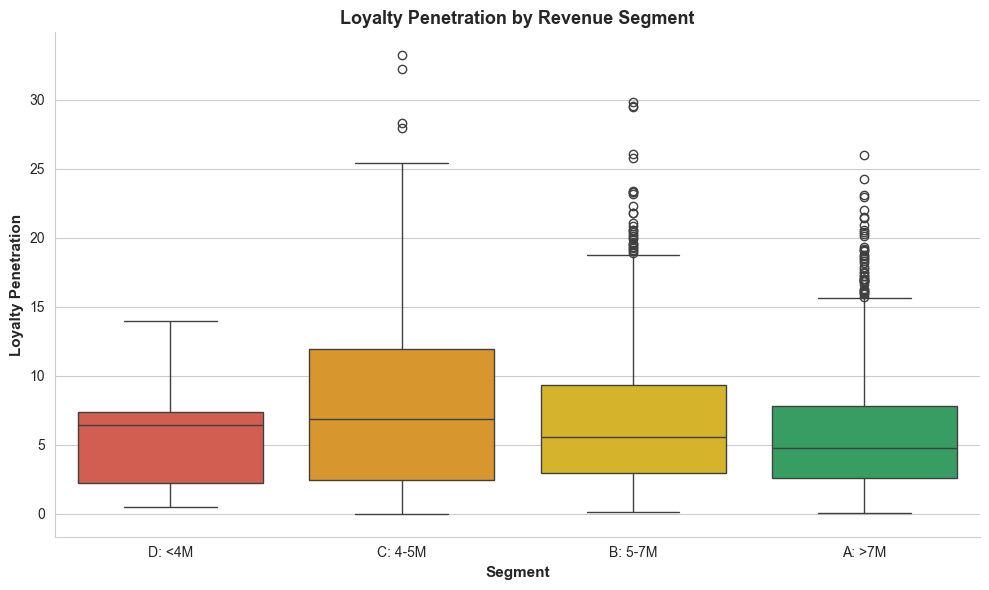

In [25]:
# ========================================
# BOXPLOT: Loyalty Penetration per Segment
# ========================================
fig, ax = plt.subplots(figsize=(10,6))

sns.boxplot(
    data=df,
    x='segment',
    y='loyalty_penetration',
    palette=['#E74C3C','#F39C12','#F1C40F','#27AE60']
)

ax.set_xlabel('Segment', fontweight='bold')
ax.set_ylabel('Loyalty Penetration', fontweight='bold')
ax.set_title('Loyalty Penetration by Revenue Segment', fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


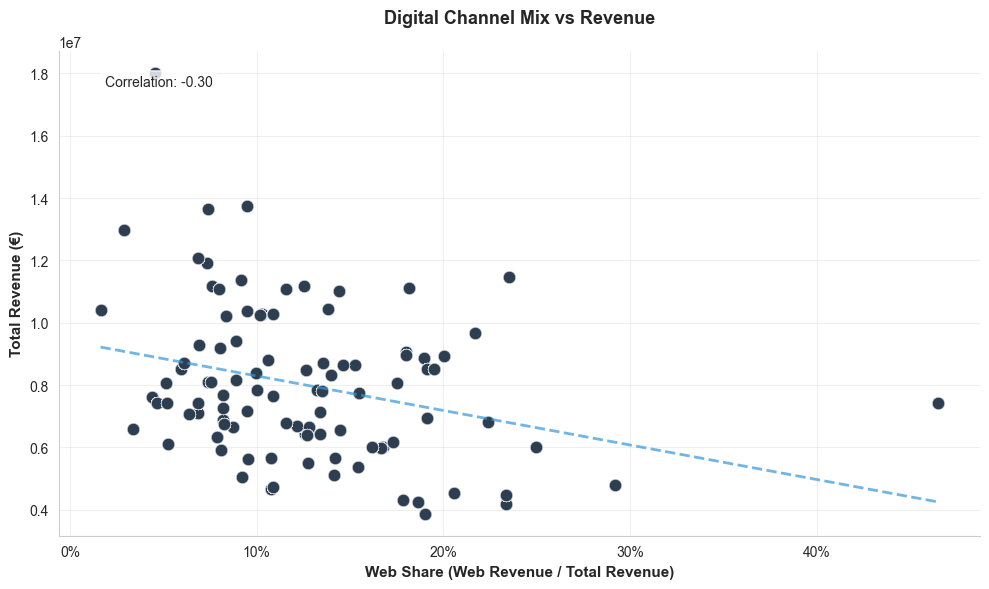

In [22]:
# =====================================================================
# 7. WEB SHARE VS TOTAL REVENUE
# =====================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Compute web share
df['web_share'] = df['CA_Web'] / df['CA_Total']

# Remove NaN and inf
plot_data = df.dropna(subset=['web_share', 'CA_Total'])
plot_data = plot_data[np.isfinite(plot_data['web_share'])]

# Plot
ax.scatter(plot_data['web_share'], 
          plot_data['CA_Total'], 
          alpha=0.6, 
          s=80,
          color=COLORS[0],
          edgecolors='white',
          linewidth=0.5)

# Add trend line
if len(plot_data) > 1:
    z = np.polyfit(plot_data['web_share'], plot_data['CA_Total'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(plot_data['web_share'].min(), plot_data['web_share'].max(), 100)
    ax.plot(x_trend, p(x_trend), "--", color=ACCENT, linewidth=2, alpha=0.7)
    
    # Calculate correlation
    correlation = np.corrcoef(plot_data['web_share'], plot_data['CA_Total'])[0,1]
    ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Formatting
ax.set_xlabel('Web Share (Web Revenue / Total Revenue)', fontweight='bold')
ax.set_ylabel('Total Revenue (€)', fontweight='bold')
ax.set_title('Digital Channel Mix vs Revenue', fontweight='bold', pad=20)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

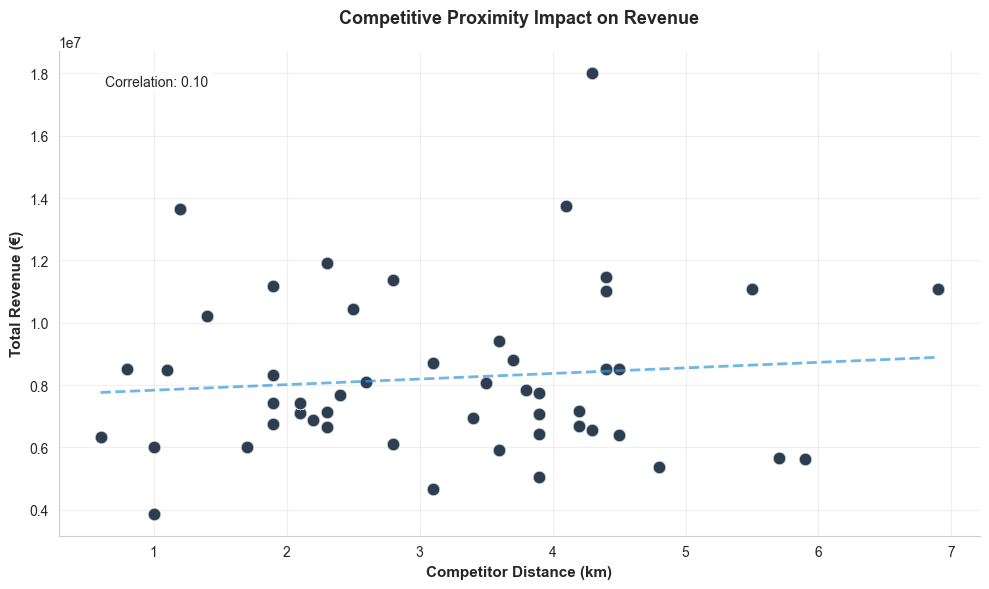

In [9]:
# =====================================================================
# 8. COMPETITOR DISTANCE VS PERFORMANCE
# =====================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Find competitor distance column
dist_col = None
for col in df.columns:
    if 'distance' in col.lower() or 'Distance' in col:
        dist_col = col
        break

if dist_col:
    # Remove NaN
    plot_data = df.dropna(subset=[dist_col, 'CA_Total'])
    
    # Plot
    ax.scatter(plot_data[dist_col], 
              plot_data['CA_Total'], 
              alpha=0.6, 
              s=80,
              color=COLORS[0],
              edgecolors='white',
              linewidth=0.5)
    
    # Add trend line
    if len(plot_data) > 1:
        z = np.polyfit(plot_data[dist_col], plot_data['CA_Total'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(plot_data[dist_col].min(), plot_data[dist_col].max(), 100)
        ax.plot(x_trend, p(x_trend), "--", color=ACCENT, linewidth=2, alpha=0.7)
        
        # Calculate correlation
        correlation = np.corrcoef(plot_data[dist_col], plot_data['CA_Total'])[0,1]
        ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Formatting
    ax.set_xlabel('Competitor Distance (km)', fontweight='bold')
    ax.set_ylabel('Total Revenue (€)', fontweight='bold')
    ax.set_title('Competitive Proximity Impact on Revenue', fontweight='bold', pad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Competitor distance column not found', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

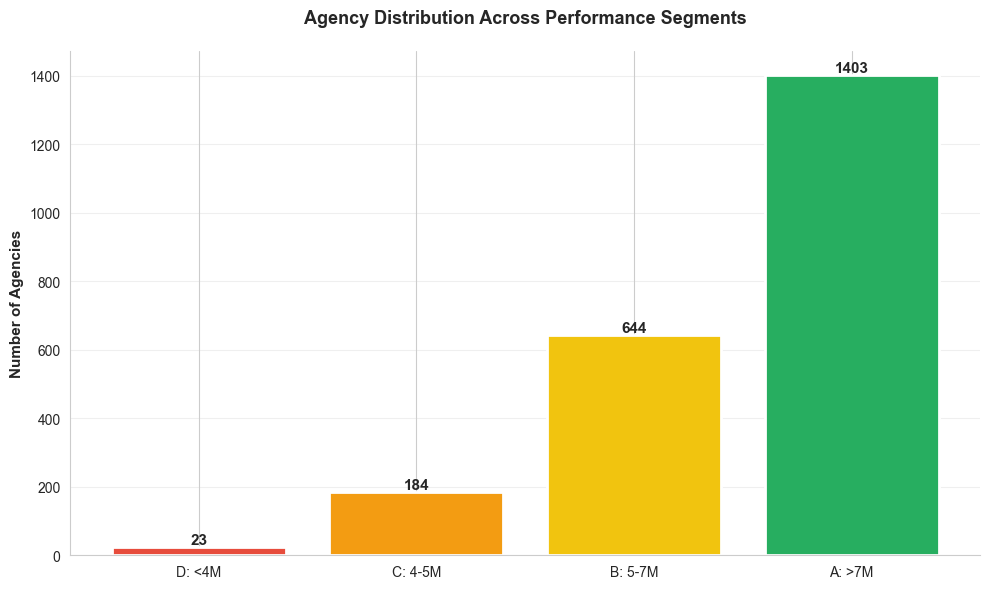

In [11]:
# =====================================================================
# 10A. MANUAL SEGMENTATION - COUNT BY CLUSTER
# =====================================================================
# Create segments
df['segment'] = pd.cut(df['CA_Total'], 
                       bins=[0, 4_000_000, 5_000_000, 7_000_000, np.inf],
                       labels=['D: <4M', 'C: 4-5M', 'B: 5-7M', 'A: >7M'])

fig, ax = plt.subplots(figsize=(10, 6))

# Count by segment
segment_counts = df['segment'].value_counts().sort_index()

# Plot
bars = ax.bar(range(len(segment_counts)), segment_counts, 
              color=['#E74C3C', '#F39C12', '#F1C40F', '#27AE60'],
              edgecolor='white', linewidth=2)

# Add value labels
for i, (idx, count) in enumerate(segment_counts.items()):
    ax.text(i, count, f'{count}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

# Formatting
ax.set_xticks(range(len(segment_counts)))
ax.set_xticklabels(segment_counts.index)
ax.set_ylabel('Number of Agencies', fontweight='bold')
ax.set_title('Agency Distribution Across Performance Segments', fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Hp\AppData\Local\Temp\ipykernel_15764\1855739666.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_data[plot_data['segment'] == seg]['CA_Total']


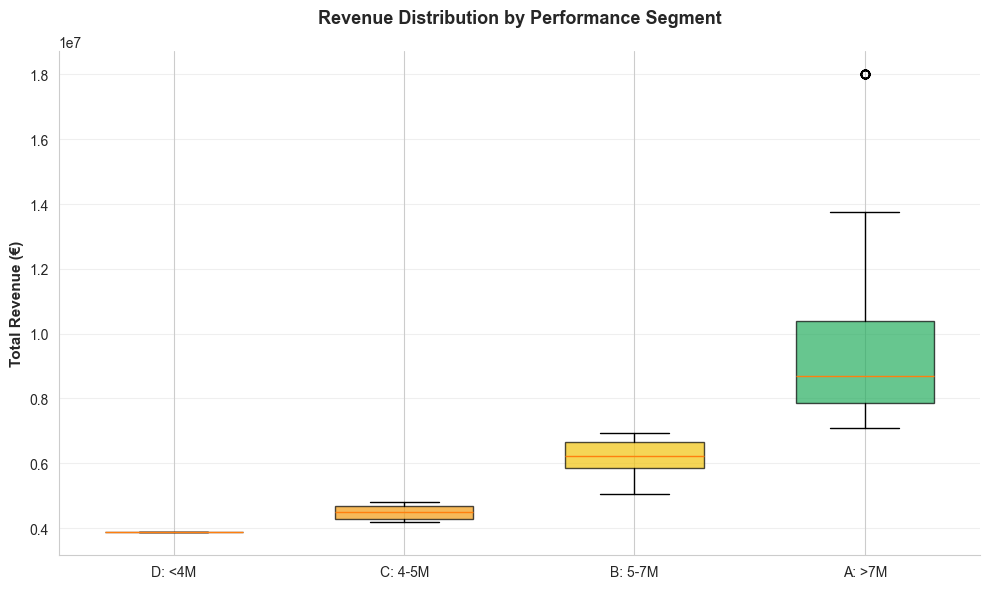

In [12]:
# =====================================================================
# 10B. MANUAL SEGMENTATION - BOXPLOT BY CLUSTER
# =====================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Remove NaN segments
plot_data = df.dropna(subset=['segment', 'CA_Total'])

# Create boxplot
bp = ax.boxplot([plot_data[plot_data['segment'] == seg]['CA_Total'] 
                 for seg in ['D: <4M', 'C: 4-5M', 'B: 5-7M', 'A: >7M']],
                labels=['D: <4M', 'C: 4-5M', 'B: 5-7M', 'A: >7M'],
                patch_artist=True,
                widths=0.6)

# Color boxes
colors = ['#E74C3C', '#F39C12', '#F1C40F', '#27AE60']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Formatting
ax.set_ylabel('Total Revenue (€)', fontweight='bold')
ax.set_title('Revenue Distribution by Performance Segment', fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

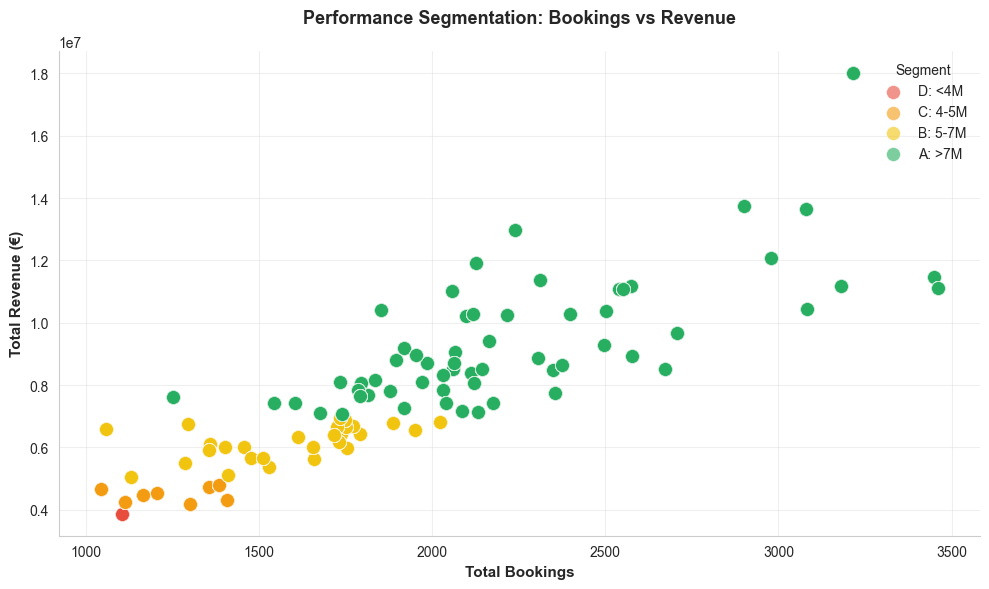

In [13]:
# =====================================================================
# 10C. MANUAL SEGMENTATION - SCATTER COLORED BY CLUSTER
# =====================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Remove NaN
plot_data = df.dropna(subset=['Nombre_Resa_Total', 'CA_Total', 'segment'])

# Color map
segment_colors = {'D: <4M': '#E74C3C', 'C: 4-5M': '#F39C12', 
                  'B: 5-7M': '#F1C40F', 'A: >7M': '#27AE60'}

# Plot each segment
for segment in ['D: <4M', 'C: 4-5M', 'B: 5-7M', 'A: >7M']:
    seg_data = plot_data[plot_data['segment'] == segment]
    ax.scatter(seg_data['Nombre_Resa_Total'], 
              seg_data['CA_Total'], 
              alpha=0.6, 
              s=100,
              label=segment,
              color=segment_colors[segment],
              edgecolors='white',
              linewidth=0.5)

# Formatting
ax.set_xlabel('Total Bookings', fontweight='bold')
ax.set_ylabel('Total Revenue (€)', fontweight='bold')
ax.set_title('Performance Segmentation: Bookings vs Revenue', fontweight='bold', pad=20)
ax.legend(frameon=False, loc='best', title='Segment', title_fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

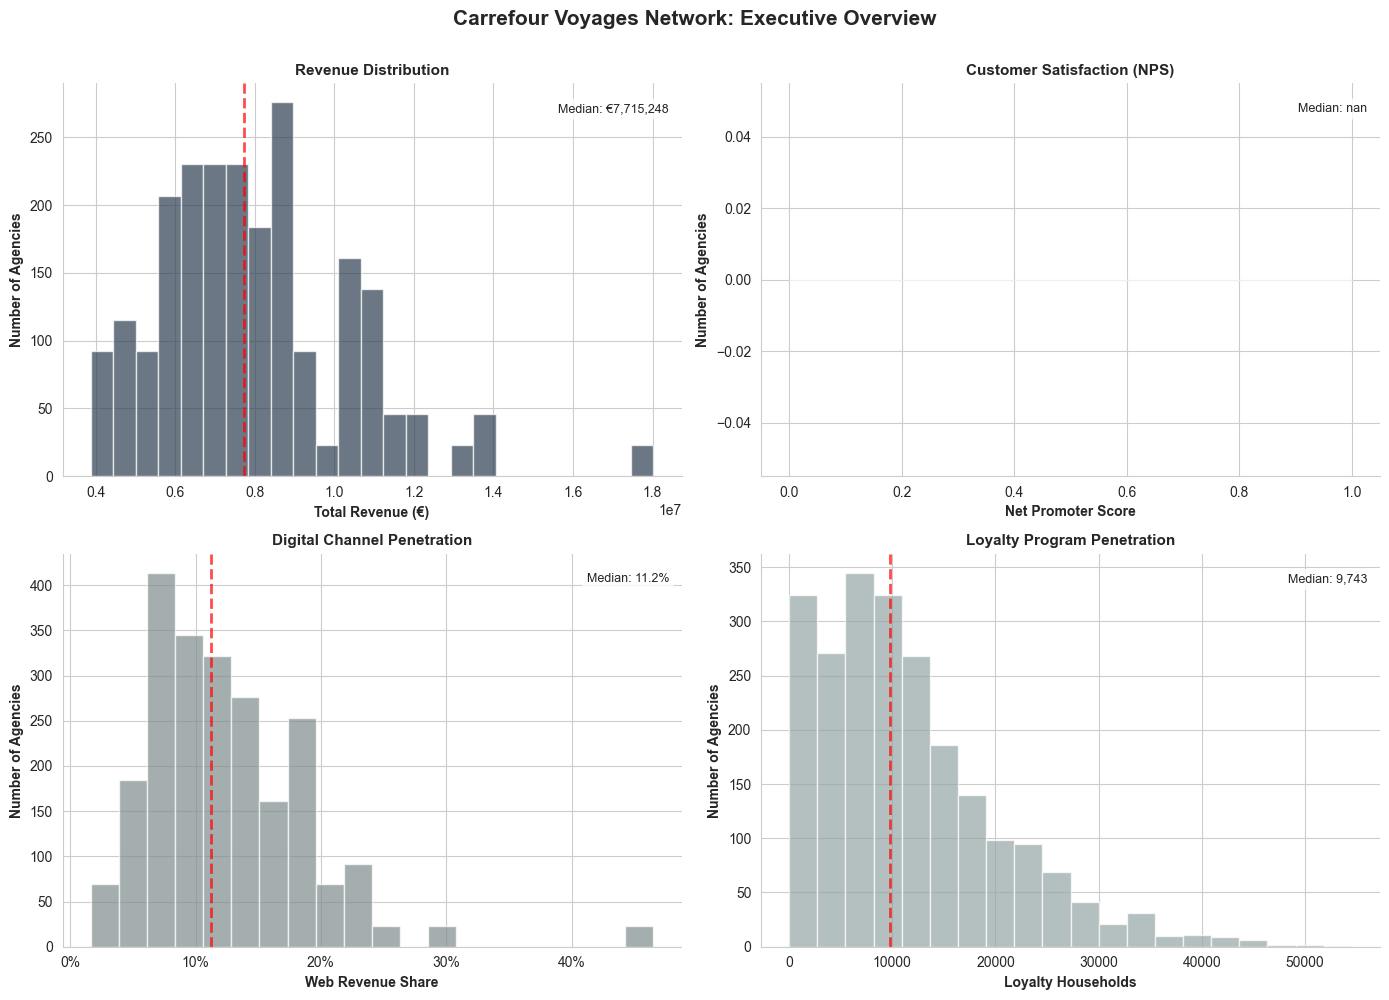

In [15]:
# =====================================================================
# 12. EXECUTIVE SUMMARY DASHBOARD (2x2 LAYOUT)
# =====================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Revenue distribution (top-left)
ax = axes[0, 0]
revenue_data = df['CA_Total'].dropna()
ax.hist(revenue_data, bins=25, alpha=0.7, color=COLORS[0], edgecolor='white')
ax.axvline(revenue_data.median(), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Total Revenue (€)', fontweight='bold', fontsize=10)
ax.set_ylabel('Number of Agencies', fontweight='bold', fontsize=10)
ax.set_title('Revenue Distribution', fontweight='bold', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.98, 0.95, f'Median: €{revenue_data.median():,.0f}', 
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. NPS distribution (top-right)
ax = axes[0, 1]
nps_data = df['NPS'].dropna()
ax.hist(nps_data, bins=20, alpha=0.7, color=COLORS[1], edgecolor='white')
ax.axvline(nps_data.median(), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Net Promoter Score', fontweight='bold', fontsize=10)
ax.set_ylabel('Number of Agencies', fontweight='bold', fontsize=10)
ax.set_title('Customer Satisfaction (NPS)', fontweight='bold', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.98, 0.95, f'Median: {nps_data.median():.1f}', 
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Web share distribution (bottom-left)
ax = axes[1, 0]
if 'web_share' in df.columns:
    web_data = df['web_share'].dropna()
    web_data = web_data[np.isfinite(web_data)]
    ax.hist(web_data, bins=20, alpha=0.7, color=COLORS[2], edgecolor='white')
    ax.axvline(web_data.median(), color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Web Revenue Share', fontweight='bold', fontsize=10)
    ax.set_ylabel('Number of Agencies', fontweight='bold', fontsize=10)
    ax.set_title('Digital Channel Penetration', fontweight='bold', fontsize=11)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    ax.text(0.98, 0.95, f'Median: {web_data.median():.1%}', 
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax.text(0.5, 0.5, 'Web share data not available', 
            ha='center', va='center', transform=ax.transAxes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 4. Loyalty households distribution (bottom-right)
ax = axes[1, 1]
loyalty_data = df['Nbre_Foyers'].dropna()
ax.hist(loyalty_data, bins=20, alpha=0.7, color=COLORS[3], edgecolor='white')
ax.axvline(loyalty_data.median(), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Loyalty Households', fontweight='bold', fontsize=10)
ax.set_ylabel('Number of Agencies', fontweight='bold', fontsize=10)
ax.set_title('Loyalty Program Penetration', fontweight='bold', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.98, 0.95, f'Median: {loyalty_data.median():,.0f}', 
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Overall title
fig.suptitle('Carrefour Voyages Network: Executive Overview', 
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Correlation between NPS and Revenue: nan


TypeError: expected non-empty vector for x

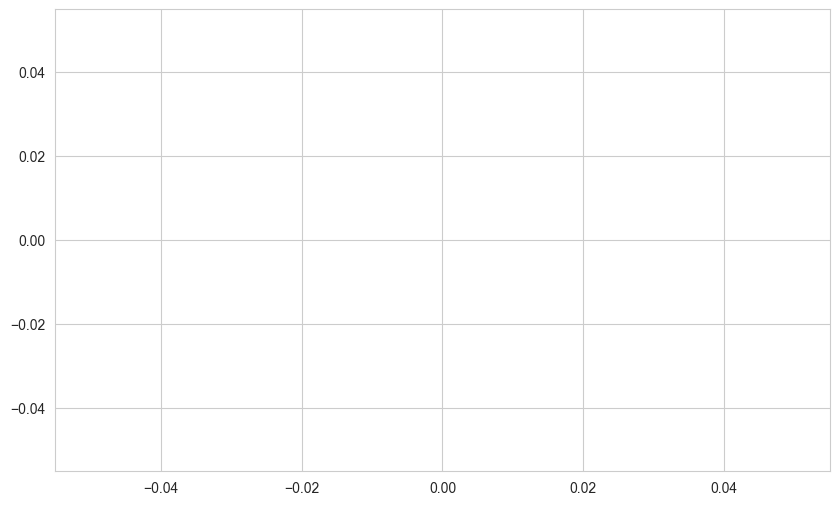

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Remove NaN values
plot_data = df.dropna(subset=['NPS', 'CA_Total'])

# Calculate correlation
correlation = plot_data['NPS'].corr(plot_data['CA_Total'])
print(f"Correlation between NPS and Revenue: {correlation:.3f}")

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(plot_data['NPS'], 
          plot_data['CA_Total'], 
          alpha=0.6, 
          s=80,
          color='#2C3E50',
          edgecolors='white',
          linewidth=1)

# Add regression line
z = np.polyfit(plot_data['NPS'], plot_data['CA_Total'], 1)
p = np.poly1d(z)
x_trend = np.linspace(plot_data['NPS'].min(), plot_data['NPS'].max(), 100)
ax.plot(x_trend, p(x_trend), "--", color='#3498DB', linewidth=2.5, alpha=0.8, label='Trend Line')

# Add correlation text box
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

# Styling
ax.set_xlabel('Net Promoter Score (NPS)', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Revenue (€)', fontweight='bold', fontsize=12)
ax.set_title('Customer Satisfaction (NPS) vs Revenue Performance', fontweight='bold', fontsize=14, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.legend(frameon=False, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()